In [1]:
%load_ext autoreload
%autoreload 2

In [36]:
from arcs.generate import GraphGenerator

graph = GraphGenerator().from_file(
    filename='../app/data/hse06_dft_data.json',
    temperature=248,
    pressure=20,
    max_reaction_length=4
)

In [ ]:
from arcs.traversal import Traversal
from arcs.generate import GenerateInitialConcentrations

gic = GenerateInitialConcentrations(graph=graph).update_ic(
    {'H2O':30,'O2':10,'SO2':10,'H2S':10,'NO2':0}
    #{'H2O':30,'O2':10,'SO2':10,'H2S':10,'NO2':10}
    #{'H2O':30,'SO2':10}
    )

t = Traversal(graph=graph)

t.rank_small_reactions_higher = {'option':True,'by_coefficients':True}

print(t.rank_small_reactions_higher)

data = t.sample(initial_concentrations=gic,ncpus=10,nsamples=1000,progress_bar=True)

{'option': True, 'by_coefficients': False}


  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
from arcs.analysis import AnalyseSampling
import pandas as pd 

analysis = AnalyseSampling() #use_markdown=True,use_latex=True)
pd.Series(analysis.reaction_statistics(data)).sort_values(ascending=False)

4 H2O + 4 SO2 = 3 H2SO4 + 1 H2S       587
1 O2 + 2 H2O + 2 SO2 = 2 H2SO4        489
3 O2 + 2 H2S = 2 H2O + 2 SO2          420
8 O2 + 1 S8 = 8 SO2                   411
1 H2O + 1 SO2 = 1 H2SO3               390
3 H2 + 1 SO2 = 2 H2O + 1 H2S          353
4 O2 + 8 H2S = 8 H2O + 1 S8           351
1 H2 + 1 H2SO4 = 2 H2O + 1 SO2        210
16 H2O + 3 S8 = 16 H2S + 8 SO2        191
2 H2 + 2 SO2 = 1 H2SO4 + 1 H2S        180
1 H2 + 1 SO2 = 1 O2 + 1 H2S           179
16 H2 + 8 SO2 = 16 H2O + 1 S8         160
16 H2O + 24 SO2 = 16 H2SO4 + 1 S8     130
4 H2 + 1 H2SO4 = 4 H2O + 1 H2S        110
3 H2 + 3 SO2 = 1 H2S + 2 H2SO3         90
4 H2SO4 + 1 S8 = 4 H2S + 8 SO2         80
8 H2O + 1 S8 = 2 H2SO4 + 6 H2S         70
24 H2 + 8 H2SO4 = 32 H2O + 1 S8        70
8 H2 + 1 S8 = 8 H2S                    61
8 H2 + 16 SO2 = 8 H2SO4 + 1 S8         60
1 H2 + 1 H2SO4 = 1 H2O + 1 H2SO3       60
1 H2 + 1 O2 + 1 SO2 = 1 H2SO4          50
2 H2 + 1 O2 = 2 H2O                    39
12 O2 + 8 H2O + 1 S8 = 8 H2SO4    

In [14]:
average_data = analysis.average_sampling(data)
average_data = average_data.loc[~(average_data==0).all(axis=1)]
average_data.round(2)

,initial,mean,diff,std
O2,10.0,3.53,-6.47,4.64
H2,0.0,0.70,0.70,2.31
H2O,30.0,15.15,-14.85,14.72
SO2,10.0,6.33,-3.67,5.33
H2SO3,0.0,0.11,0.11,0.74
H2S,10.0,3.70,-6.30,4.18
H2SO4,0.0,2.22,2.22,3.21
S8,0.0,0.70,0.70,0.64


<Axes: >

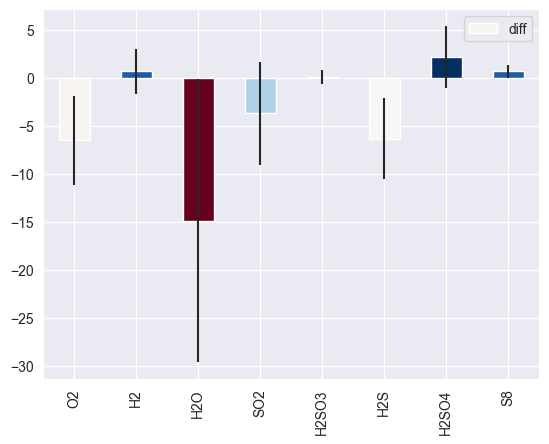

In [15]:
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

sns.set_style('darkgrid')
sns.set_palette('pastel')


norm = colors.Normalize(vmin=average_data['diff'].min(), vmax=average_data['diff'].max())
cmap = cm.RdBu  # or any other colormap

bar_colors = [cmap(norm(value)) for value in average_data['diff']]

average_data.plot.bar(y='diff',yerr='std',color=bar_colors)

effect of adding NO2

In [24]:
from arcs.traversal import Traversal
from arcs.generate import GenerateInitialConcentrations

gic = GenerateInitialConcentrations(graph=graph).update_ic(
    #{'H2O':30,'O2':10,'SO2':10,'H2S':10,'NO2':0}
    {'H2O':30,'O2':10,'SO2':10,'H2S':10,'NO2':10}
    #{'H2O':30,'SO2':10}
    )

t = Traversal(graph=graph)

t.rank_small_reactions_higher = {'option':True,'by_coefficients':False}
print(t.rank_small_reactions_higher)

data = t.sample(initial_concentrations=gic,ncpus=10,nsamples=1000,progress_bar=True)

{'option': True, 'by_coefficients': False}


  0%|          | 0/1000 [00:00<?, ?it/s]

In [25]:
from arcs.analysis import AnalyseSampling
import pandas as pd 

analysis = AnalyseSampling() #use_markdown=True,use_latex=True)
pd.Series(analysis.reaction_statistics(data)).sort_values(ascending=False)

3 O2 + 2 H2S = 2 H2O + 2 SO2        294
4 O2 + 8 H2S = 8 H2O + 1 S8         260
1 H2O + 1 SO2 = 1 H2SO3             250
1 O2 + 2 H2O + 2 SO2 = 2 H2SO4      240
8 O2 + 1 S8 = 8 SO2                 226
                                   ... 
4 H2 + 2 NO2 = 4 H2O + 1 N2           2
1 H2 + 2 O2 + 2 NO = 2 HNO3           2
1 H2SO4 + 1 NO = 1 H2SO3 + 1 NO2      2
8 O2 + 1 S8 + 8 HNO3 = 8 NOHSO4       2
8 O2 + 8 H2O + 1 S8 = 8 H2SO3         2
Length: 104, dtype: int64

In [26]:
average_data = analysis.average_sampling(data)
average_data = average_data.loc[~(average_data==0).all(axis=1)]
average_data.round(5)

,initial,mean,diff,std
O2,10.0,5.81611,-4.18389,6.51529
H2,0.0,0.53451,0.53451,2.00320
N2,0.0,0.48758,0.48758,1.20069
NH3,0.0,0.27304,0.27304,1.16100
H2O,30.0,19.78064,-10.21936,14.02322
SO2,10.0,7.91552,-2.08448,6.03909
H2SO3,0.0,0.24754,0.24754,1.18167
H2S,10.0,3.98672,-6.01328,4.43181
H2SO4,0.0,1.74208,1.74208,3.49059
HNO3,0.0,0.79134,0.79134,1.99088


<Axes: >

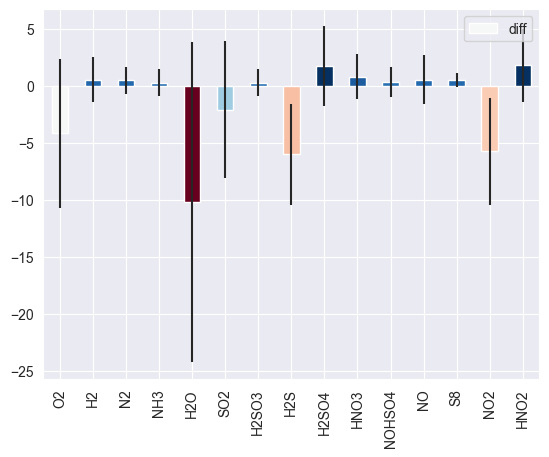

In [27]:
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

sns.set_style('darkgrid')
sns.set_palette('pastel')


norm = colors.Normalize(vmin=average_data['diff'].min(), vmax=average_data['diff'].max())
cmap = cm.RdBu  # or any other colormap

bar_colors = [cmap(norm(value)) for value in average_data['diff']]

average_data.plot.bar(y='diff',yerr='std',color=bar_colors)

testing

In [28]:
from arcs.traversal import Traversal
from arcs.generate import GenerateInitialConcentrations

gic = GenerateInitialConcentrations(graph=graph).update_ic(
    #{'H2O':30,'O2':10,'SO2':10,'H2S':10,'NO2':0}
    {'H2O':30,'O2':10,'SO2':10,'H2S':10,'NO2':10}
    #{'H2O':30,'SO2':10}
    )

t = Traversal(graph=graph)
t.rank_small_reactions_higher = {'option':True,'by_coefficients':True}
random_compounds = t.get_weighted_random_compounds(gic)
random_compounds

['SO2', 'NO2', 'H2O', 'O2']

In [29]:
random_reactions = t.get_weighted_reaction_rankings(random_compounds)
random_reactions = dict(sorted(random_reactions.items(),key=lambda item: item[1]))
random_reactions

{177: 8.845645547282267,
 54: 9.597397764126042,
 364: 134.02791689651585,
 436: 139.7695424720423}

In [30]:
for i in random_reactions:
    eq = t.generate_chempy_eqsystem(i)
    fconc = t.chempy_equilibrium_concentrations(gic,eq)
    if fconc:
        print(i,eq.string())

In [35]:
graph.nodes()[436]

{'reaction': {'reaction_string': '1 S8 + 16 NO2 = 8 SO2 + 16 NO',
  'reactants': {'S8': 1, 'NO2': 16},
  'products': {'SO2': 8, 'NO': 16}},
 'equilibrium_constant': inf}

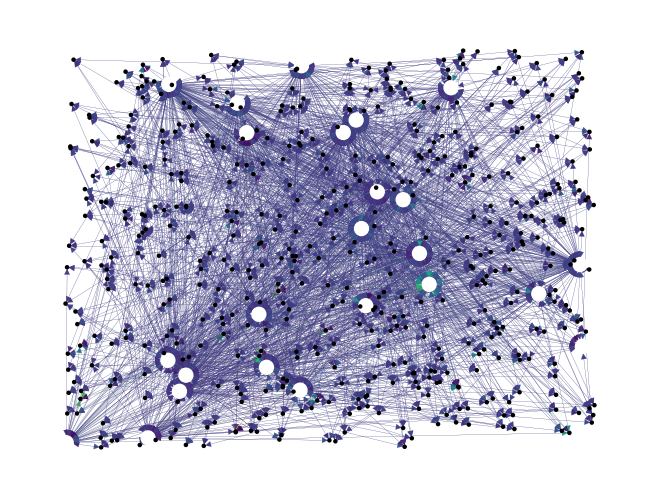

In [31]:
import matplotlib.pyplot as plt
import networkx as nx 
import numpy as np 
G = graph 

node_colours= []
node_sizes = []
for node in list(G.nodes):
    if isinstance(node,int):
        node_colours.append('black')
        node_sizes.append(5)
    else:
        node_colours.append('white')
        node_sizes.append(100)

edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
vmin = np.min(weights)
vmax = np.max(weights)
cmap = plt.cm.viridis

nx.draw_random(G,node_color=node_colours,node_size=node_sizes,edgelist=edges,edge_color=weights,width=0.1,edge_cmap=cmap,vmin=vmin,vmax=vmax)

### Speed Test 

In [ ]:
from arcs.traversal import Traversal
from arcs.generate import GenerateInitialConcentrations

gic = GenerateInitialConcentrations(graph=graph).update_ic({'H2O':100,'H2':30,'O2':50,'H2S':100,'NO2':200,'N2':300})
t = Traversal(graph=graph)

In [ ]:
data = t.sample(initial_concentrations=gic,ncpus=1)

In [ ]:
data = t.sample(initial_concentrations=gic,ncpus=2)

In [ ]:
data = t.sample(initial_concentrations=gic,ncpus=4)

In [ ]:
data = t.sample(initial_concentrations=gic,ncpus=10)